In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import pickle


from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from src.models import cgan
 
from src.common.helperfunctions import *
from src.common.accuracy_XGboost import *


import xgboost as xgb
import time
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    recall_score,
    precision_score,
    f1_score,
    accuracy_score,
    confusion_matrix,
)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file_name = 'data/raw/creditcard.csv'
df = pd.read_csv(file_name)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
train, test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

In [4]:
sc = StandardScaler()
train.loc[:,'Amount'] = sc.fit_transform(train.Amount.values.reshape(-1, 1))
train.loc[:,'Time'] = sc.fit_transform(train.Time.values.reshape(-1, 1))
test.loc[:,'Amount'] = sc.transform(test.Amount.values.reshape(-1, 1))
test.loc[:,'Time'] = sc.transform(test.Time.values.reshape(-1, 1))
# train.drop('Time',axis=1, inplace=True)
# test.drop('Time', axis=1, inplace=True)

C:\Users\chinne\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\chinne\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\chinne\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pan

In [5]:
train.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,2.278450e+05,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,...,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,2.278450e+05,227845.000000
mean,-1.328462e-16,0.000916,-0.000384,-0.000920,-0.001458,0.000997,-0.000613,0.001090,-0.000383,0.000961,...,0.000215,-0.001215,0.000175,-0.000217,-0.000979,-0.000192,-0.000032,0.000257,-5.624473e-16,0.001729
std,1.000002e+00,1.958337,1.656602,1.514545,1.415853,1.387667,1.336803,1.243493,1.188643,1.097553,...,0.732617,0.725311,0.627103,0.605446,0.521764,0.482443,0.401821,0.329776,1.000002e+00,0.041548
min,-1.996122e+00,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.320155,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-9.895244,-15.430084,-3.470760e-01,0.000000
25%,-8.556106e-01,-0.919918,-0.597971,-0.890786,-0.849270,-0.688802,-0.768573,-0.552156,-0.208431,-0.642386,...,-0.228730,-0.542809,-0.161296,-0.354887,-0.317835,-0.327476,-0.070960,-0.052980,-3.251092e-01,0.000000
50%,-2.123794e-01,0.017978,0.066050,0.179041,-0.020959,-0.054711,-0.274846,0.041272,0.022233,-0.050414,...,-0.029639,0.005491,-0.010595,0.040766,0.015101,-0.052011,0.001359,0.011366,-2.607777e-01,0.000000
75%,9.373337e-01,1.315548,0.803898,1.025399,0.741630,0.611173,0.396056,0.570639,0.327504,0.599040,...,0.186080,0.527408,0.148202,0.439790,0.350453,0.240813,0.091400,0.078464,-4.463973e-02,0.000000
max,1.642496e+00,2.454930,22.057729,4.187811,16.875344,34.801666,73.301626,120.589494,20.007208,10.392889,...,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,1.004303e+02,1.000000


In [6]:
train.drop('Time', axis = 1,inplace=True)
test.drop('Time', axis = 1,inplace=True)

C:\Users\chinne\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [7]:
label_col = []
feature_cols = []
label_col = [i for i in train.columns if 'Class' in i]
feature_cols = [i for i in train.columns if i not in label_col]

In [8]:
train_Class = train[train.Class == 1]

In [9]:
train_noFraud = train[train.Class == 0]

In [10]:
train_noFraud = train_noFraud.sample(n=train_Class.shape[0], random_state=42)

In [11]:
train_noFraud.shape[0]

394

In [12]:
train_Class = train_Class.append(train_noFraud)
train_Class = train_Class.sample(frac=1)

In [13]:
train_Class.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 788 entries, 88520 to 154697
Data columns (total 30 columns):
V1        788 non-null float64
V2        788 non-null float64
V3        788 non-null float64
V4        788 non-null float64
V5        788 non-null float64
V6        788 non-null float64
V7        788 non-null float64
V8        788 non-null float64
V9        788 non-null float64
V10       788 non-null float64
V11       788 non-null float64
V12       788 non-null float64
V13       788 non-null float64
V14       788 non-null float64
V15       788 non-null float64
V16       788 non-null float64
V17       788 non-null float64
V18       788 non-null float64
V19       788 non-null float64
V20       788 non-null float64
V21       788 non-null float64
V22       788 non-null float64
V23       788 non-null float64
V24       788 non-null float64
V25       788 non-null float64
V26       788 non-null float64
V27       788 non-null float64
V28       788 non-null float64
Amount    788 non-nu

In [14]:
train_Class[train_Class==1]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
88520,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
234705,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
50147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
153823,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
237225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
236039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
150146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# mxs = MinMaxScaler()
# train.iloc[:,:] = mxs.fit_transform(train.iloc[:,:].values)
# test.iloc[:,:] = mxs.transform(test.iloc[:,:].values)
# # train.drop('Time',axis=1, inplace=True)
# # test.drop('Time', axis=1, inplace=True)

# Train conditional GAN

In [16]:
# train_Class.drop('Class', axis = 1,inplace=True)

In [17]:
train_Class.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class'],
      dtype='object')

In [18]:
dataloader = prepareDataset(train_Class, batch_size = 128, device = 'cpu', withLabel = True)

In [19]:
dataloader.dataset.features.size(1)

29

In [57]:
label_col = ['Class']

In [59]:
dataloader.dataset.features

tensor([[ 1.2776,  0.6669, -0.5660,  ..., -0.0298,  0.0431, -0.3441],
        [-2.2192,  0.7278, -5.4582,  ...,  0.4133, -0.1314, -0.3471],
        [-2.6794,  1.2669,  0.3812,  ..., -0.5382, -0.2143, -0.0150],
        ...,
        [ 1.2613,  2.7268, -5.4350,  ...,  0.4682,  0.2805, -0.3408],
        [ 0.5052, -0.7685, -0.4177,  ...,  0.1324,  0.0235, -0.3078],
        [-4.2212,  2.8711, -5.8887,  ...,  0.1367, -0.5998, -0.3173]])

In [20]:
dataloader.dataset.label.size(1)

1

Generator(
  (main): Sequential(
    (0): Linear(in_features=33, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace)
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace)
    (6): Linear(in_features=256, out_features=29, bias=True)
  )
)
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=30, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace)
    (6): Linear(in_features=64, out_features=1, bias=True)
    (7): Sigmoid()
  )
)
Starting Training Loop...
788 788
epoch: 0, Accuracy: 0.7411167512690355
[0/1001]	Loss_D: 0.4653	Loss_G: 0.7068	


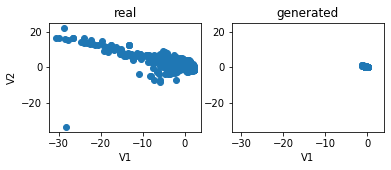

788 788
epoch: 10, Accuracy: 0.8439086294416244
[10/1001]	Loss_D: 0.4471	Loss_G: 3.8478	


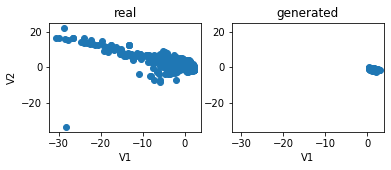

788 788
epoch: 20, Accuracy: 0.7055837563451777
[20/1001]	Loss_D: 0.3841	Loss_G: 3.9636	


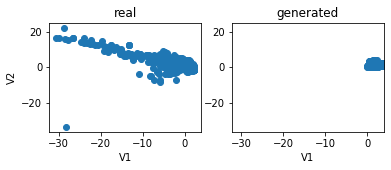

788 788
epoch: 30, Accuracy: 0.934010152284264
[30/1001]	Loss_D: 0.6423	Loss_G: 2.5854	


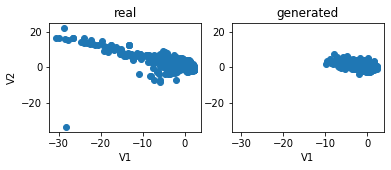

788 788
epoch: 40, Accuracy: 0.9606598984771574
[40/1001]	Loss_D: 0.4345	Loss_G: 1.8007	


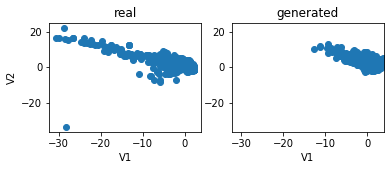

788 788
epoch: 50, Accuracy: 0.9137055837563451
[50/1001]	Loss_D: 0.5096	Loss_G: 1.5772	


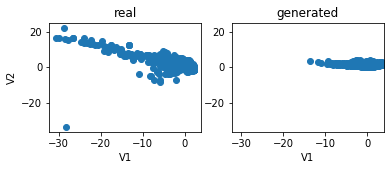

788 788
epoch: 60, Accuracy: 0.9809644670050761
[60/1001]	Loss_D: 0.4856	Loss_G: 1.5059	


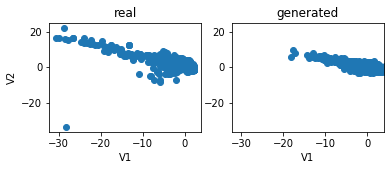

788 788
epoch: 70, Accuracy: 0.9454314720812182
[70/1001]	Loss_D: 0.5162	Loss_G: 1.8857	


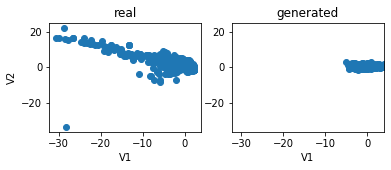

788 788
epoch: 80, Accuracy: 0.9733502538071066
[80/1001]	Loss_D: 0.4330	Loss_G: 2.1558	


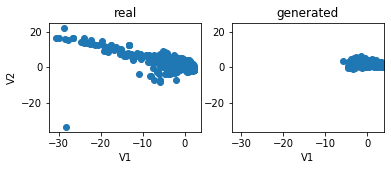

788 788
epoch: 90, Accuracy: 0.949238578680203
[90/1001]	Loss_D: 0.4563	Loss_G: 1.4229	


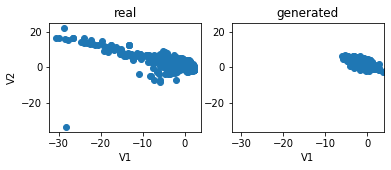

788 788
epoch: 100, Accuracy: 0.9784263959390863
[100/1001]	Loss_D: 0.5289	Loss_G: 1.5768	


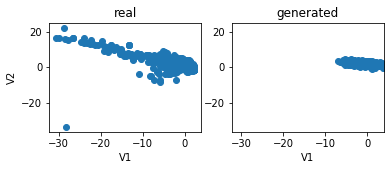

788 788
epoch: 110, Accuracy: 0.9695431472081218
[110/1001]	Loss_D: 0.4418	Loss_G: 1.6252	


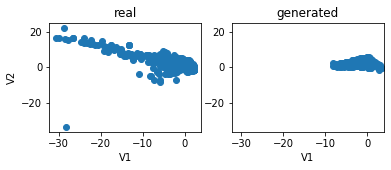

788 788
epoch: 120, Accuracy: 0.9771573604060914
[120/1001]	Loss_D: 0.4849	Loss_G: 2.0957	


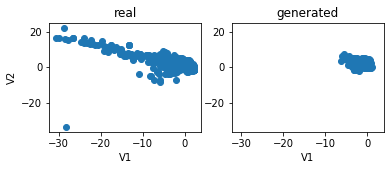

788 788
epoch: 130, Accuracy: 0.9022842639593909
[130/1001]	Loss_D: 0.3417	Loss_G: 2.3877	


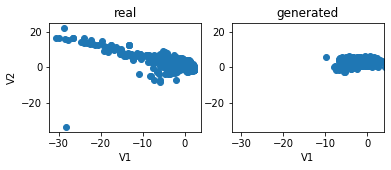

788 788
epoch: 140, Accuracy: 0.9644670050761421
[140/1001]	Loss_D: 0.4188	Loss_G: 1.7503	


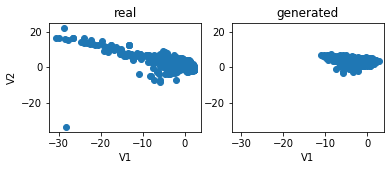

788 788
epoch: 150, Accuracy: 0.8743654822335025
[150/1001]	Loss_D: 0.4006	Loss_G: 2.1177	


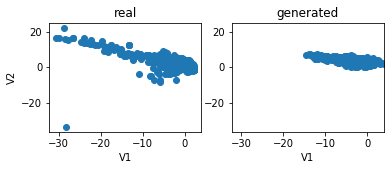

788 788
epoch: 160, Accuracy: 0.932741116751269
[160/1001]	Loss_D: 0.4086	Loss_G: 1.8643	


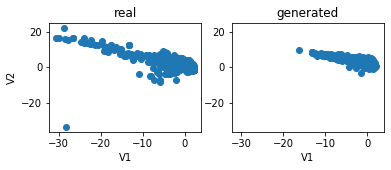

788 788
epoch: 170, Accuracy: 0.9314720812182741
[170/1001]	Loss_D: 0.3737	Loss_G: 1.8888	


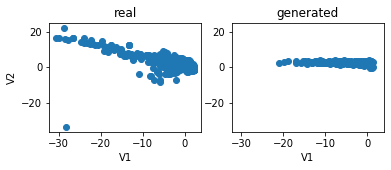

788 788
epoch: 180, Accuracy: 0.9479695431472082
[180/1001]	Loss_D: 0.4051	Loss_G: 2.0230	


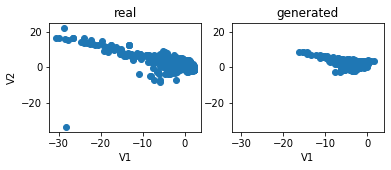

788 788
epoch: 190, Accuracy: 0.8883248730964467
[190/1001]	Loss_D: 0.3582	Loss_G: 2.0099	


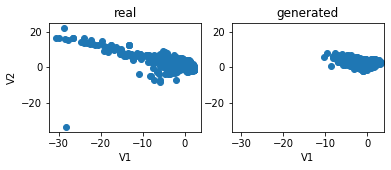

788 788
epoch: 200, Accuracy: 0.9416243654822335
[200/1001]	Loss_D: 0.3677	Loss_G: 2.0882	


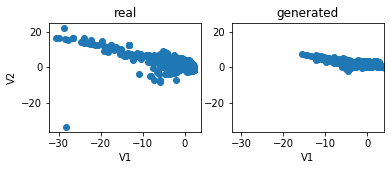

788 788
epoch: 210, Accuracy: 0.9657360406091371
[210/1001]	Loss_D: 0.4441	Loss_G: 2.1698	


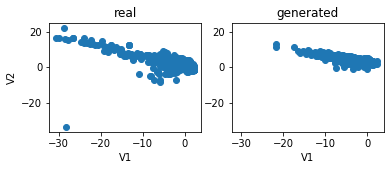

788 788
epoch: 220, Accuracy: 0.8883248730964467
[220/1001]	Loss_D: 0.3948	Loss_G: 2.2480	


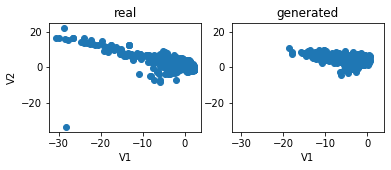

788 788
epoch: 230, Accuracy: 0.9784263959390863
[230/1001]	Loss_D: 0.4147	Loss_G: 2.1249	


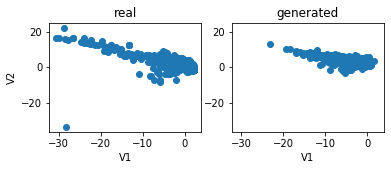

788 788
epoch: 240, Accuracy: 0.9175126903553299
[240/1001]	Loss_D: 0.4947	Loss_G: 2.1842	


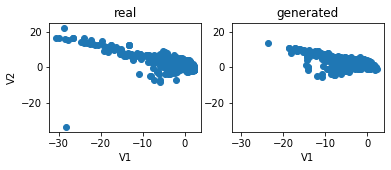

788 788
epoch: 250, Accuracy: 0.9454314720812182
[250/1001]	Loss_D: 0.3754	Loss_G: 2.1096	


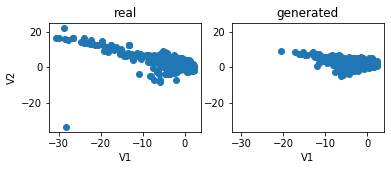

788 788
epoch: 260, Accuracy: 0.9695431472081218
[260/1001]	Loss_D: 0.3807	Loss_G: 2.4748	


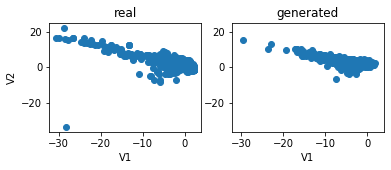

788 788
epoch: 270, Accuracy: 0.9771573604060914
[270/1001]	Loss_D: 0.4148	Loss_G: 2.0206	


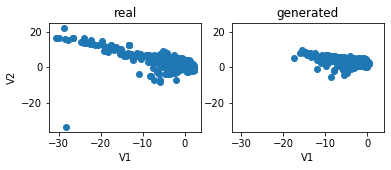

788 788
epoch: 280, Accuracy: 0.9695431472081218
[280/1001]	Loss_D: 0.3510	Loss_G: 2.6444	


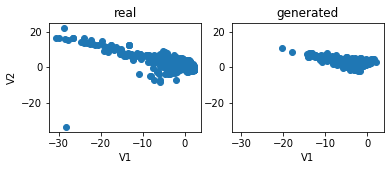

788 788
epoch: 290, Accuracy: 0.9187817258883249
[290/1001]	Loss_D: 0.3508	Loss_G: 2.5325	


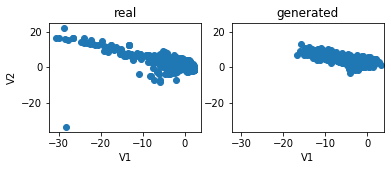

788 788
epoch: 300, Accuracy: 0.9631979695431472
[300/1001]	Loss_D: 0.3511	Loss_G: 2.5399	


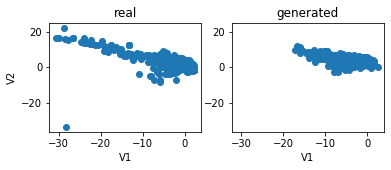

788 788
epoch: 310, Accuracy: 0.950507614213198
[310/1001]	Loss_D: 0.4043	Loss_G: 2.6046	


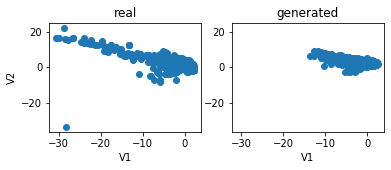

788 788
epoch: 320, Accuracy: 0.8248730964467005
[320/1001]	Loss_D: 0.3094	Loss_G: 2.5894	


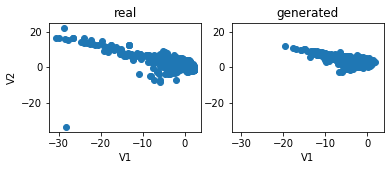

788 788
epoch: 330, Accuracy: 0.9555837563451777
[330/1001]	Loss_D: 0.2989	Loss_G: 2.4605	


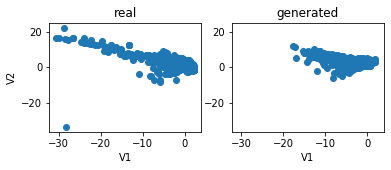

788 788
epoch: 340, Accuracy: 0.883248730964467
[340/1001]	Loss_D: 0.3039	Loss_G: 2.5621	


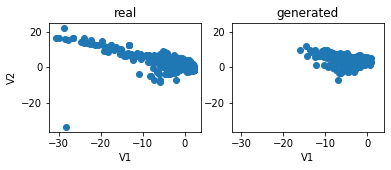

788 788
epoch: 350, Accuracy: 0.9416243654822335
[350/1001]	Loss_D: 0.3026	Loss_G: 2.9395	


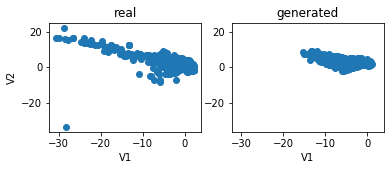

788 788
epoch: 360, Accuracy: 0.9276649746192893
[360/1001]	Loss_D: 0.2993	Loss_G: 3.2946	


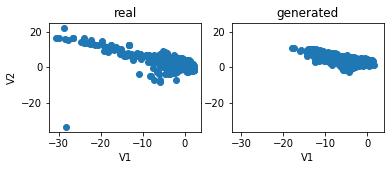

788 788
epoch: 370, Accuracy: 0.9302030456852792
[370/1001]	Loss_D: 0.2553	Loss_G: 3.0593	


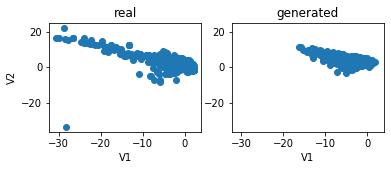

788 788
epoch: 380, Accuracy: 0.8908629441624365
[380/1001]	Loss_D: 0.3862	Loss_G: 2.9762	


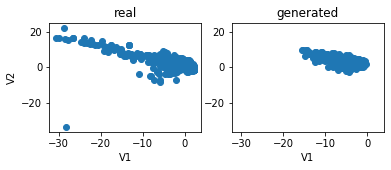

788 788
epoch: 390, Accuracy: 0.9111675126903553
[390/1001]	Loss_D: 0.2699	Loss_G: 3.1788	


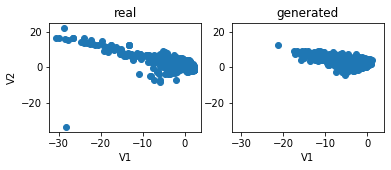

788 788
epoch: 400, Accuracy: 0.9073604060913706
[400/1001]	Loss_D: 0.2762	Loss_G: 3.1854	


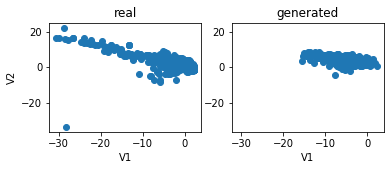

788 788
epoch: 410, Accuracy: 0.9441624365482234
[410/1001]	Loss_D: 0.2289	Loss_G: 3.0633	


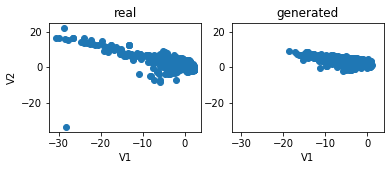

788 788
epoch: 420, Accuracy: 0.9251269035532995
[420/1001]	Loss_D: 0.2293	Loss_G: 3.3619	


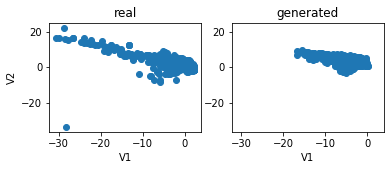

788 788
epoch: 430, Accuracy: 0.9251269035532995
[430/1001]	Loss_D: 0.3426	Loss_G: 3.2404	


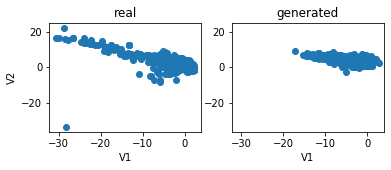

788 788
epoch: 440, Accuracy: 0.916243654822335
[440/1001]	Loss_D: 0.2611	Loss_G: 3.3582	


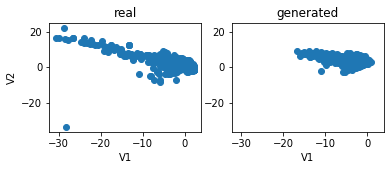

788 788
epoch: 450, Accuracy: 0.9441624365482234
[450/1001]	Loss_D: 0.2478	Loss_G: 3.4014	


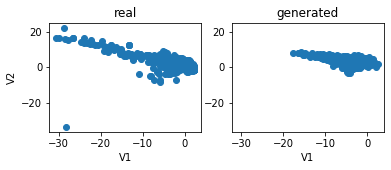

788 788
epoch: 460, Accuracy: 0.8692893401015228
[460/1001]	Loss_D: 0.2693	Loss_G: 3.5572	


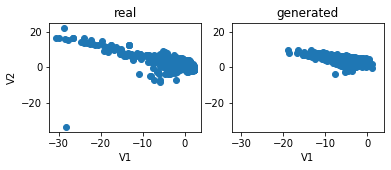

788 788
epoch: 470, Accuracy: 0.9137055837563451
[470/1001]	Loss_D: 0.2757	Loss_G: 3.5786	


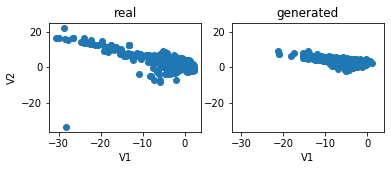

788 788
epoch: 480, Accuracy: 0.9200507614213198
[480/1001]	Loss_D: 0.1984	Loss_G: 3.6832	


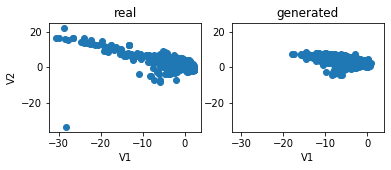

788 788
epoch: 490, Accuracy: 0.9022842639593909
[490/1001]	Loss_D: 0.2189	Loss_G: 3.2093	


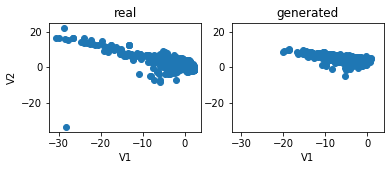

788 788
epoch: 500, Accuracy: 0.9213197969543148
[500/1001]	Loss_D: 0.1665	Loss_G: 3.6049	


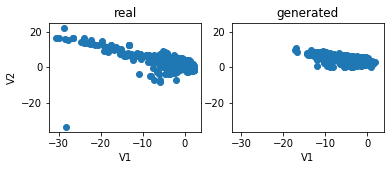

788 788
epoch: 510, Accuracy: 0.883248730964467
[510/1001]	Loss_D: 0.1887	Loss_G: 3.6397	


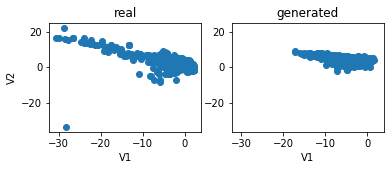

788 788
epoch: 520, Accuracy: 0.9378172588832487
[520/1001]	Loss_D: 0.2384	Loss_G: 3.9227	


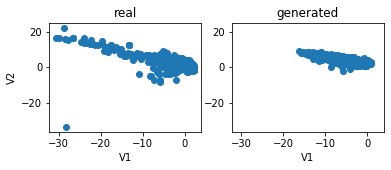

788 788
epoch: 530, Accuracy: 0.9200507614213198
[530/1001]	Loss_D: 0.2085	Loss_G: 3.8861	


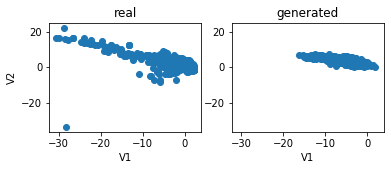

788 788
epoch: 540, Accuracy: 0.9517766497461929
[540/1001]	Loss_D: 0.1833	Loss_G: 4.2174	


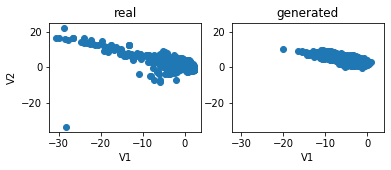

788 788
epoch: 550, Accuracy: 0.934010152284264
[550/1001]	Loss_D: 0.3065	Loss_G: 4.9291	


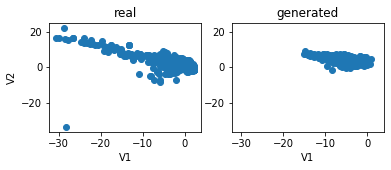

788 788
epoch: 560, Accuracy: 0.9073604060913706
[560/1001]	Loss_D: 0.1524	Loss_G: 4.2306	


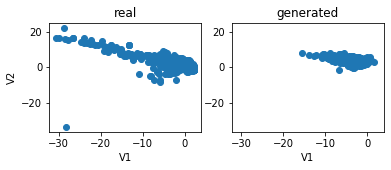

788 788
epoch: 570, Accuracy: 0.9606598984771574
[570/1001]	Loss_D: 0.1490	Loss_G: 4.1030	


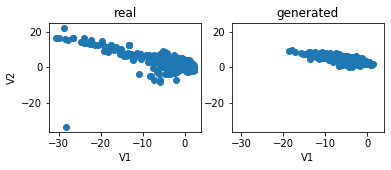

788 788
epoch: 580, Accuracy: 0.9555837563451777
[580/1001]	Loss_D: 0.1414	Loss_G: 4.4068	


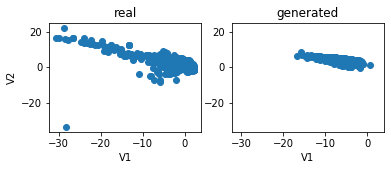

788 788
epoch: 590, Accuracy: 0.9530456852791879
[590/1001]	Loss_D: 0.1524	Loss_G: 4.0130	


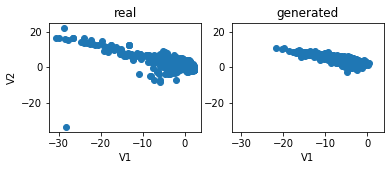

788 788
epoch: 600, Accuracy: 0.9010152284263959
[600/1001]	Loss_D: 0.2044	Loss_G: 5.0991	


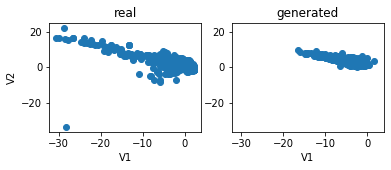

788 788
epoch: 610, Accuracy: 0.9175126903553299
[610/1001]	Loss_D: 0.1325	Loss_G: 4.0618	


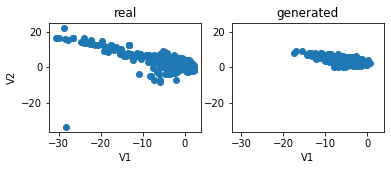

788 788
epoch: 620, Accuracy: 0.9022842639593909
[620/1001]	Loss_D: 0.4584	Loss_G: 5.7375	


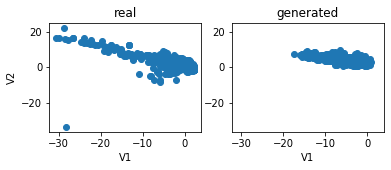

788 788
epoch: 630, Accuracy: 0.9403553299492385
[630/1001]	Loss_D: 0.1502	Loss_G: 4.2965	


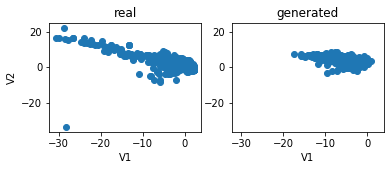

788 788
epoch: 640, Accuracy: 0.9098984771573604
[640/1001]	Loss_D: 0.1945	Loss_G: 4.5943	


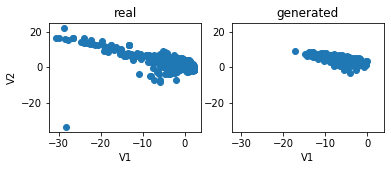

788 788
epoch: 650, Accuracy: 0.9251269035532995
[650/1001]	Loss_D: 0.1652	Loss_G: 4.1845	


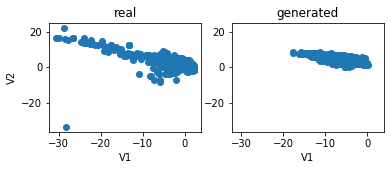

788 788
epoch: 660, Accuracy: 0.9530456852791879
[660/1001]	Loss_D: 0.1963	Loss_G: 4.7060	


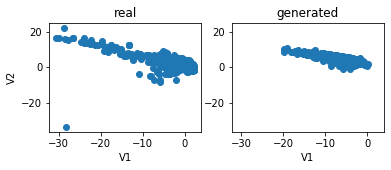

788 788
epoch: 670, Accuracy: 0.9022842639593909
[670/1001]	Loss_D: 0.1193	Loss_G: 4.2005	


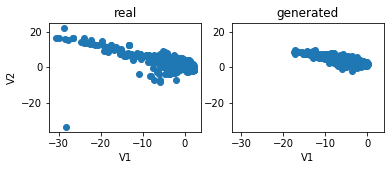

788 788
epoch: 680, Accuracy: 0.9581218274111675
[680/1001]	Loss_D: 0.1210	Loss_G: 4.2229	


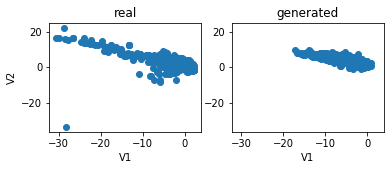

788 788
epoch: 690, Accuracy: 0.9530456852791879
[690/1001]	Loss_D: 0.1139	Loss_G: 4.3809	


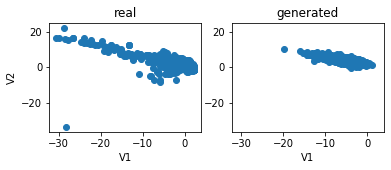

788 788
epoch: 700, Accuracy: 0.8236040609137056
[700/1001]	Loss_D: 0.1338	Loss_G: 4.8932	


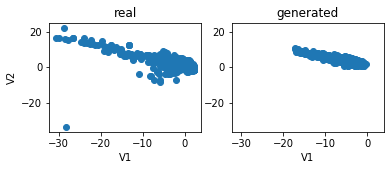

788 788
epoch: 710, Accuracy: 0.9517766497461929
[710/1001]	Loss_D: 0.1459	Loss_G: 3.8600	


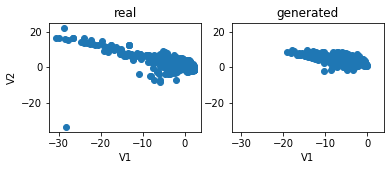

788 788
epoch: 720, Accuracy: 0.950507614213198
[720/1001]	Loss_D: 0.1200	Loss_G: 4.1428	


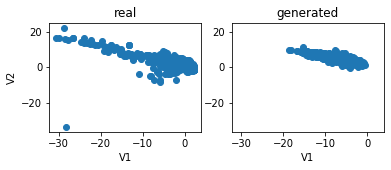

788 788
epoch: 730, Accuracy: 0.9441624365482234
[730/1001]	Loss_D: 0.1346	Loss_G: 4.4504	


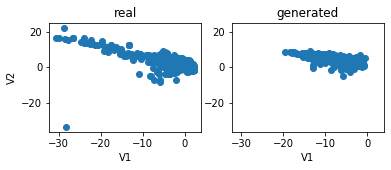

788 788
epoch: 740, Accuracy: 0.9441624365482234
[740/1001]	Loss_D: 0.2326	Loss_G: 5.0064	


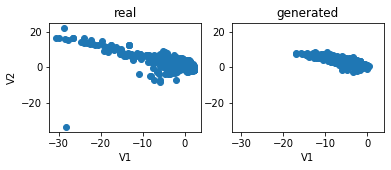

788 788
epoch: 750, Accuracy: 0.9517766497461929
[750/1001]	Loss_D: 0.1309	Loss_G: 4.2849	


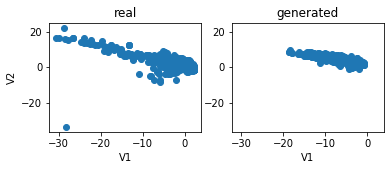

788 788
epoch: 760, Accuracy: 0.9568527918781726
[760/1001]	Loss_D: 0.1286	Loss_G: 4.1798	


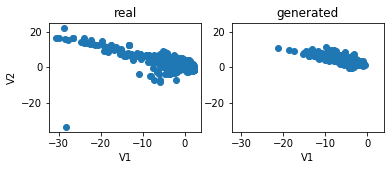

788 788
epoch: 770, Accuracy: 0.9390862944162437
[770/1001]	Loss_D: 0.1384	Loss_G: 4.8425	


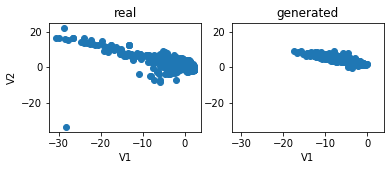

788 788
epoch: 780, Accuracy: 0.9479695431472082
[780/1001]	Loss_D: 0.1182	Loss_G: 4.1217	


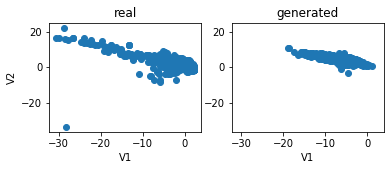

788 788
epoch: 790, Accuracy: 0.9263959390862944
[790/1001]	Loss_D: 0.1209	Loss_G: 4.5078	


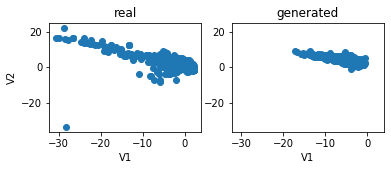

788 788
epoch: 800, Accuracy: 0.9390862944162437
[800/1001]	Loss_D: 0.1219	Loss_G: 4.7949	


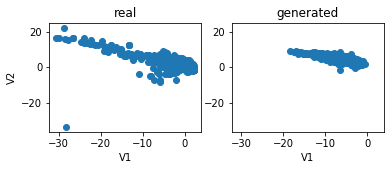

788 788
epoch: 810, Accuracy: 0.9467005076142132
[810/1001]	Loss_D: 0.1546	Loss_G: 4.8210	


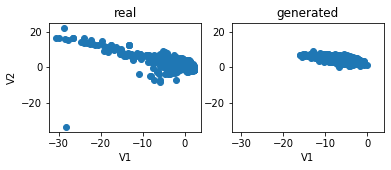

788 788
epoch: 820, Accuracy: 0.9302030456852792
[820/1001]	Loss_D: 0.1043	Loss_G: 4.5997	


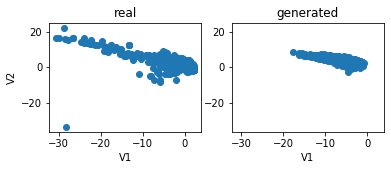

788 788
epoch: 830, Accuracy: 0.9073604060913706
[830/1001]	Loss_D: 0.1137	Loss_G: 4.4430	


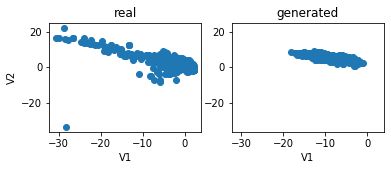

788 788
epoch: 840, Accuracy: 0.934010152284264
[840/1001]	Loss_D: 0.1945	Loss_G: 5.1319	


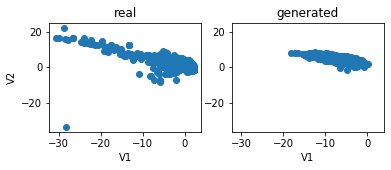

788 788
epoch: 850, Accuracy: 0.9746192893401016
[850/1001]	Loss_D: 0.1138	Loss_G: 4.4865	


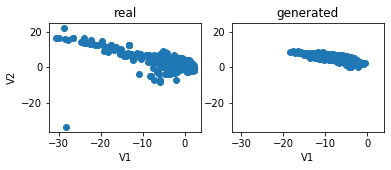

788 788
epoch: 860, Accuracy: 0.9670050761421319
[860/1001]	Loss_D: 0.1659	Loss_G: 4.7605	


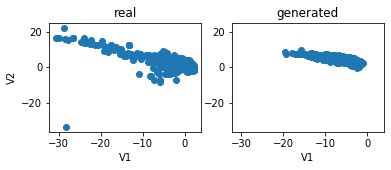

788 788
epoch: 870, Accuracy: 0.9378172588832487
[870/1001]	Loss_D: 0.1556	Loss_G: 5.0625	


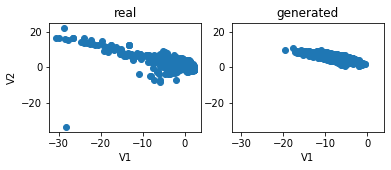

788 788
epoch: 880, Accuracy: 0.883248730964467
[880/1001]	Loss_D: 0.1459	Loss_G: 4.6732	


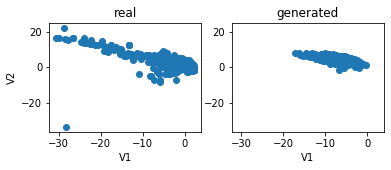

788 788
epoch: 890, Accuracy: 0.9593908629441624
[890/1001]	Loss_D: 0.1182	Loss_G: 4.2667	


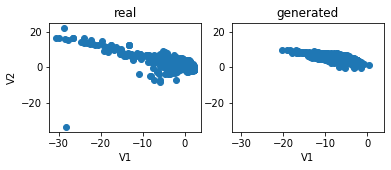

788 788
epoch: 900, Accuracy: 0.9695431472081218
[900/1001]	Loss_D: 0.1345	Loss_G: 4.6029	


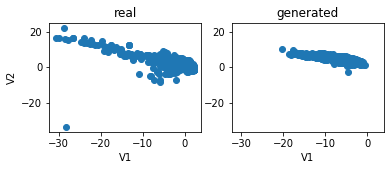

788 788
epoch: 910, Accuracy: 0.9390862944162437
[910/1001]	Loss_D: 0.1822	Loss_G: 4.1038	


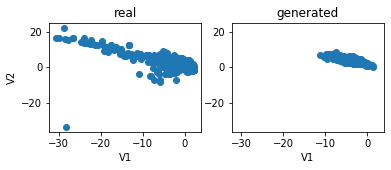

788 788
epoch: 920, Accuracy: 0.9720812182741116
[920/1001]	Loss_D: 0.1391	Loss_G: 4.6350	


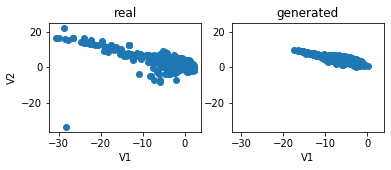

788 788
epoch: 930, Accuracy: 0.9708121827411168
[930/1001]	Loss_D: 0.1475	Loss_G: 4.2246	


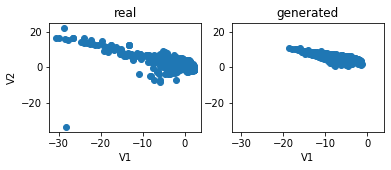

788 788
epoch: 940, Accuracy: 0.9568527918781726
[940/1001]	Loss_D: 0.2217	Loss_G: 4.6866	


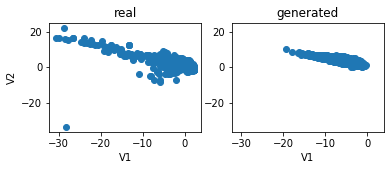

788 788
epoch: 950, Accuracy: 0.9593908629441624
[950/1001]	Loss_D: 0.1298	Loss_G: 4.1805	


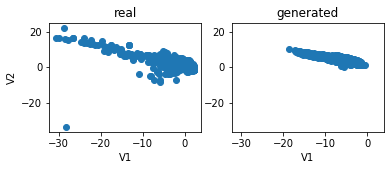

788 788
epoch: 960, Accuracy: 0.9670050761421319
[960/1001]	Loss_D: 0.1715	Loss_G: 4.7238	


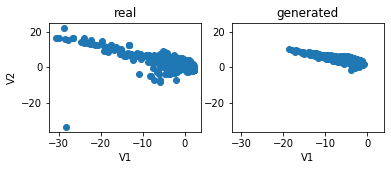

788 788
epoch: 970, Accuracy: 0.9631979695431472
[970/1001]	Loss_D: 0.1106	Loss_G: 4.2399	


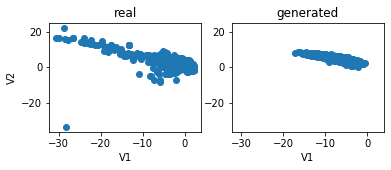

788 788
epoch: 980, Accuracy: 0.9695431472081218
[980/1001]	Loss_D: 0.1289	Loss_G: 4.4080	


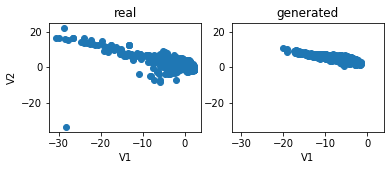

788 788
epoch: 990, Accuracy: 0.9530456852791879
[990/1001]	Loss_D: 0.1145	Loss_G: 4.2885	


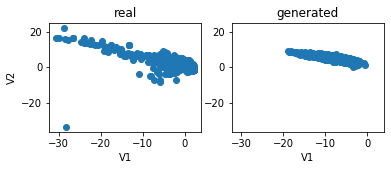

788 788
epoch: 1000, Accuracy: 0.949238578680203
[1000/1001]	Loss_D: 0.1779	Loss_G: 4.9291	


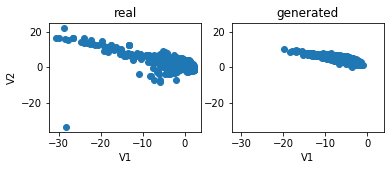

It took  163.75904059410095


In [69]:
xgblosses, D_losses, G_losses, D_RealLosses, D_FakeLosses, generated_data, real_data_list = cgan.train(dataloader, randomNoise_dim = 32, hidden_dim = 64, realData_dim =dataloader.dataset.features.size(1), lr = 0.002, num_epochs=1000, feature_cols=feature_cols, label_col= [], device='cpu')

In [22]:
for i in range(xgblosses.size):
    if np.round(xgblosses[i],6) == np.round(min(xgblosses[10:]),6):
        best_round = i*10
        print(best_round)

660


0.7296954314720813


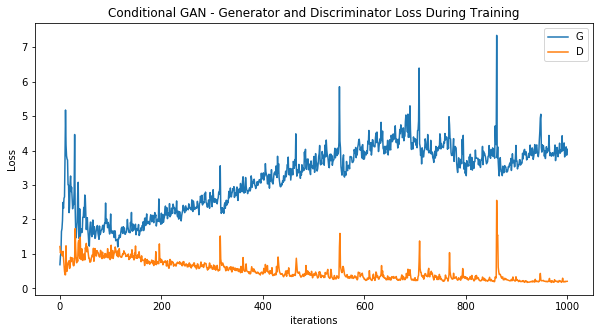

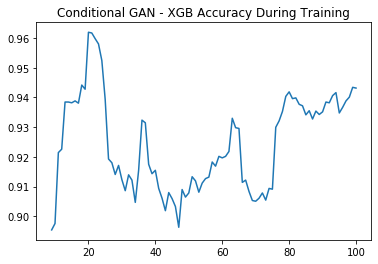

In [23]:
w=10
print(min(xgblosses[10:]))
plt.figure(figsize=(10,5))
plt.title(f"Conditional GAN - Generator and Discriminator Loss During Training")
b = pd.DataFrame(G_losses[:]).rolling(w).mean()
# c = pd.DataFrame(D_RealLosses[:]).rolling(w).mean()
# d = pd.DataFrame(D_FakeLosses[:]).rolling(w).mean()
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
# plt.plot(b,label="G")
# plt.plot(c,label="D")
# plt.plot(d,label="C")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig(f'reports/figures/cgan/cGAN.png')
plt.show()


a = pd.DataFrame(xgblosses[:]).rolling(w).mean()
plt.title(f"Conditional GAN - XGB Accuracy During Training")
plt.plot(a)
plt.savefig(f'reports/figures/cgan/xgblosses_cGAN.png')
plt.show()

In [24]:
amount=train.shape[0]
device='cpu'

In [25]:
train.shape[0]

227845

In [26]:
randomNoise_dim = 32; hidden_dim = 64; realData_dim =dataloader.dataset.features.size(1)

In [33]:
more_data = cgan.generate_data(best_round, randomNoise_dim, hidden_dim, realData_dim, amount, 'cpu')

In [35]:
more_data = more_data.detach().numpy()

In [36]:
b = np.ones((more_data.shape[0],more_data.shape[1]+1))
b[:,:-1] = more_data

In [37]:
b.shape

(227845, 30)

In [38]:
label_col = ['Class']

In [39]:
type(label_col)

list

In [40]:
df_generatedData = pd.DataFrame(b, columns = feature_cols + label_col)
df_generatedData.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.473871,2.445929,-4.224523,3.742002,-0.413047,-1.340973,-2.333575,0.474221,-2.398067,-3.902706,...,0.263067,-0.389621,-0.110163,-0.782658,0.832104,0.562256,0.720409,0.387914,-0.345618,1.0
1,-2.494339,2.802293,-4.302862,4.154064,-2.864137,-1.349023,-6.046917,1.829777,-2.942487,-6.655558,...,1.247262,1.246315,0.342296,-0.077414,-0.444850,0.511153,0.949477,0.413953,-0.261697,1.0
2,-10.480616,7.801702,-14.185849,10.112253,-9.360284,-3.412256,-13.000884,6.692495,-8.339895,-14.748490,...,2.734800,0.606899,0.191649,0.717625,0.019028,0.868888,1.057191,0.037965,0.371827,1.0
3,-0.948592,3.382048,-6.240097,5.123992,-2.267378,-2.194897,-5.424031,1.169274,-4.153106,-7.679027,...,0.971969,-0.429059,-0.034420,-0.398693,0.869081,0.818140,1.144972,0.804169,-0.143628,1.0
4,-7.084982,3.274392,-10.078363,5.893855,-3.751125,-2.256097,-8.119108,4.056728,-5.054528,-10.045196,...,0.979111,-0.333395,0.136367,-0.378076,0.647121,1.367887,1.794174,-0.321769,0.032755,1.0


In [41]:
train.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class'],
      dtype='object')

In [42]:
train = train.append(df_generatedData)
train = train.sample(frac=1)

In [43]:
train.shape

(455690, 30)

In [44]:
train.isnull().sum()

V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [45]:
train_y = train.Class

In [46]:
train_y

270564    0.0
207687    1.0
98792     0.0
218912    1.0
64656     0.0
67994     1.0
122863    0.0
72812     1.0
162340    1.0
51377     0.0
30426     1.0
64920     1.0
214025    1.0
86700     1.0
139193    0.0
62434     1.0
88709     1.0
149859    0.0
95374     1.0
164902    1.0
104537    1.0
9708      0.0
8654      0.0
241803    0.0
165622    1.0
56955     0.0
273968    0.0
116705    0.0
208850    1.0
24456     1.0
         ... 
231545    0.0
103383    0.0
196495    0.0
8041      1.0
80632     0.0
234620    0.0
278887    0.0
239363    0.0
104118    1.0
23570     0.0
41613     0.0
210976    0.0
67265     0.0
141494    0.0
132222    0.0
132179    1.0
172989    0.0
73857     1.0
236151    0.0
106587    0.0
100462    0.0
177295    1.0
242142    0.0
80262     0.0
107407    0.0
105523    0.0
185193    1.0
144228    0.0
183901    0.0
178703    1.0
Name: Class, Length: 455690, dtype: float64

In [47]:
train_y.isnull().sum()

0

In [48]:
train_X = train

In [49]:
train_X.drop('Class', axis=1, inplace=True)

# XGBoost

In [50]:
train_y.head()

270564    0.0
207687    1.0
98792     0.0
218912    1.0
64656     0.0
Name: Class, dtype: float64

In [51]:
train_X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
270564,-2.014030,2.465140,-1.554214,-1.260047,0.835095,-0.319351,0.902035,0.112513,1.473265,2.195532,...,1.131429,-0.695573,-0.895732,0.056209,-0.036390,-0.010880,0.054864,0.143986,-0.414735,-0.311851
207687,-1.637387,3.954141,-7.620510,5.936079,-3.176772,-2.747442,-6.696779,1.498087,-4.676094,-9.930324,...,1.342850,1.313795,-0.571168,-0.031343,-0.257779,0.970887,0.571820,1.492613,0.938875,-0.061735
98792,-1.050327,-0.081322,0.802016,-4.049828,-0.636479,-0.480345,-0.372936,0.654360,0.304268,-1.258476,...,-0.681679,-0.186688,-0.168985,-0.252665,-0.984274,0.245145,-0.109830,0.205434,0.070308,-0.287413
218912,-0.170505,3.367381,-3.615907,5.662224,-1.565528,-0.971901,-3.538100,1.092510,-3.708480,-4.031441,...,0.563120,0.876310,0.283968,0.266838,-0.099386,-0.038010,1.002533,0.770906,0.258412,-0.513250
64656,0.428736,-2.168225,-0.518700,-0.154042,-1.291947,-0.495073,0.196049,-0.195926,-0.577549,0.355569,...,0.914568,0.458362,0.214590,-0.550179,0.107453,0.480629,-0.082440,-0.096297,0.082831,1.627821


In [52]:
test_X = test.iloc[:,:-1]
test_y = test.iloc[:,-1]

In [53]:
train_y.shape

(455690,)

In [54]:
start_time = time.time()
dtrain = xgb.DMatrix(train_X, train_y, feature_names=feature_cols)
dtest = xgb.DMatrix(test_X, feature_names=feature_cols)

results_dict = {}

param = {
        'max_depth':5, 
        'eta':0.3, 
        'verbosity': 1, 
        'objective':'binary:logistic', 
        'eval_metric': 'auc', 
        'seed': 42
        }

model = xgb.train(param, dtrain, num_boost_round=100)
# make prediction
preds = np.round(model.predict(dtest))
elapsed_time = time.time() - start_time
print('Time elapsed to train: ', elapsed_time)

C:\Users\chinne\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\chinne\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Time elapsed to train:  42.1740300655365


In [55]:
print('---' * 45)
print('XGBoost ROC/AUC: {:.6f}'.format(roc_auc_score(test_y, preds)))
print('Recall Score: {:.6f}'.format(recall_score(test_y, preds)))
print('Precision Score: {:.6f}'.format(precision_score(test_y, preds)))
print('F1 Score: {:.6f}'.format(f1_score(test_y, preds)))
print('Accuracy Score: {:.6f}'.format(accuracy_score(test_y, preds)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------
XGBoost ROC/AUC: 0.913195
Recall Score: 0.826531
Precision Score: 0.910112
F1 Score: 0.866310
Accuracy Score: 0.999561
---------------------------------------------------------------------------------------------------------------------------------------
